# 数据生成

## 生成测试数据

In [ ]:
'''
处理流程  一：
1、 PDF文件
2、 通过 fitz 打开PDF，抽取文字，抽取图片
3、 生成数学公式图片，随机插入到图片中，并记录位置信息, 注意图片大小的问题

处理流程 二：
直接采用PIL的方式生成
'''




In [ ]:
'''
1、https://www.jianshu.com/p/f57cc64b9f5e PDF转图片
2、http://blog.alivate.com.au/poppler-windows/

'''

image size: (6942, 5175, 3)


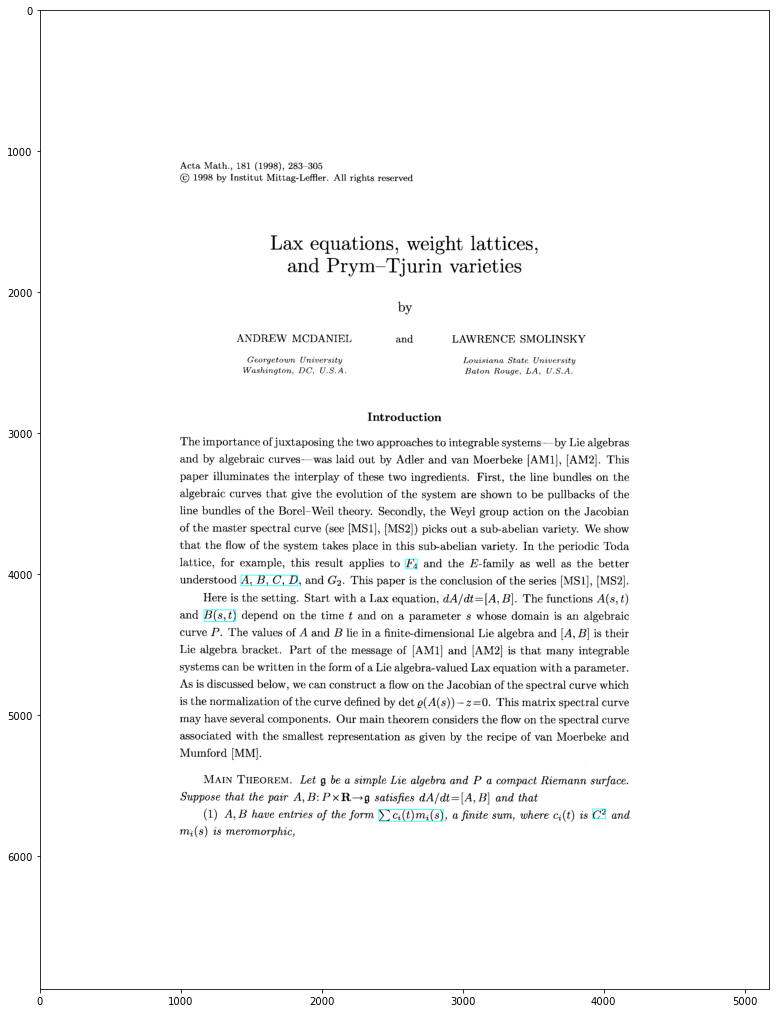

In [14]:
%matplotlib inline
import importlib
from matplotlib import pyplot as plt 
import cv2
image_path = 'D:\\PROJECT_TW\\git\\data\\mathdetect\\images\\1\\1.png'
fig = plt.figure(figsize=(20,18))
image = cv2.imread(image_path, cv2.IMREAD_COLOR) 
print('image size:', image.shape)
cv2.rectangle(image, (2592, 3893), (2673, 3962), (0, 255, 255), 3)
cv2.rectangle(image, (1424, 4007), (1827, 4082), (0, 255, 255), 3)
cv2.rectangle(image, (2402, 5669), (2857, 5752), (0, 255, 255), 3)
cv2.rectangle(image, (1162, 4253), (1387, 4336), (0, 255, 255), 3)
cv2.rectangle(image, (3918, 5665), (4009, 5734), (0, 255, 255), 3)
plt.imshow(image)
plt.show()


# 测试

In [21]:
# import sys
# sys.path.append('./lib/mathdetect')
# print(sys.path)
# from ssd import SSD, build_ssd
import ssd as ssd
from data import *
import argparse
import importlib
importlib.reload(argparse)
importlib.reload(ssd)

def parse_args():
    parser = argparse.ArgumentParser(description='Single Shot MultiBox Detection')
    parser.add_argument('--trained_model', default='D:\\PROJECT_TW\\git\\data\\mathdetect\\weights\\AMATH512_e1GTDB.pth',type=str, help='Trained state_dict file path to open')
    parser.add_argument('--save_folder', default='eval/', type=str, help='Dir to save results')
    parser.add_argument('--visual_threshold', default=0.25, type=float,help='Final confidence threshold')
    parser.add_argument('--cuda', default=False, type=bool,help='Use cuda to train model')
    parser.add_argument('--dataset_root', default='../', help='Location of VOC root directory')
    parser.add_argument('--test_data', default="testing_data", help='testing data file')
    parser.add_argument('--verbose', default=False, type=bool, help='plot output')
    parser.add_argument('--suffix', default="_10", type=str, help='suffix of directory of images for testing')
    parser.add_argument('--exp_name', default="SSD", help='Name of the experiment. Will be used to generate output')
    parser.add_argument('--model_type', default=512, type=int, help='Type of ssd model, ssd300 or ssd512')
    parser.add_argument('--use_char_info', default=False, type=bool, help='Whether or not to use char info')
    parser.add_argument('--limit', default=-1, type=int, help='limit on number of test examples')
    parser.add_argument('--cfg', default="hboxes512", type=str,help='Type of network: either gtdb or math_gtdb_512')
    parser.add_argument('--batch_size', default=16, type=int,help='Batch size for training')
    parser.add_argument('--num_workers', default=4, type=int,help='Number of workers used in data loading')
#     parser.add_argument('--kernel', default="3 3",nargs='+', help='Kernel size for feature layers: 3 3 or 1 5')
#     parser.add_argument('--padding', default="1 1", nargs='+',help='Padding for feature layers: 1 1 or 0 2')
    parser.add_argument('--neg_mining', default=True, type=bool,help='Whether or not to use hard negative mining with ratio 1:3')
    parser.add_argument('--log_dir', default="logs", type=str,help='dir to save the logs')
    parser.add_argument('--stride', default=0.1, type=float,help='Stride to use for sliding window')
    parser.add_argument('--window', default=1200, type=int,help='Sliding window size')
    parser.add_argument('-f', default=None, type=str, help="Dummy arg so we can load in Jupyter Notebooks")
    args = parser.parse_args([])
    return args

args = parse_args()
args.kernel = (1,5)
args.padding = (0,2)
gpu_id=0
num_classes=2
net = ssd.build_ssd(args, 'test', exp_cfg[args.cfg], gpu_id, args.model_type, num_classes)
mod = torch.load(args.trained_model,map_location=torch.device('cpu'))
mod_new = {k.replace('module.',''):v for k,v in mod.items()}
net.load_state_dict(mod_new)
# for k, v in mod:
#     print(k)
# net.load_state_dict(torch.load(args.trained_model,map_location=torch.device('cpu')))

# import utils.visualize as visualize

torch.Size([38227, 4])


<All keys matched successfully>

In [13]:
import cv2
from torchvision import datasets, transforms
import torch
image_path = 'D:\\PROJECT_TW\\git\\data\\mathdetect\\images\\1_02.png'
def generate_metadata(image, window, stride):
    metadata = []
    height, width, channels = image.shape
    n_horizontal = np.ceil(width / window)  # 4
    n_vertical = np.ceil(height / window) 
    print(n_horizontal, n_vertical)
    crop_size = window
    h = np.arange(0, n_horizontal - 1 + stride, stride)
    v = np.arange(0, n_vertical - 1 + stride, stride)
    for i in h:
        for j in v:
            x_l = int(np.round(crop_size * i))
            y_l = int(np.round(crop_size * j))
            metadata.append([x_l, y_l])
    return metadata

image = cv2.imread(image_path, cv2.IMREAD_COLOR)
metadata = generate_metadata(image, args.window, args.stride)
# BaseTransform 参数 size, mean  mean=(104, 117, 123)
trans =BaseTransform(args.model_type,(104, 117, 123))
img = trans(image)
img = torch.from_numpy(img[0])
img.unsqueeze_(0)
img = img.permute(0,3,1,2)
net.eval()
y, debug_boxes, debug_scores = net(img)

1.0 1.0


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:664: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


In [18]:
print(net)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

(1020, 820, 3)
[(469, 901, 767, 920)]
(469, 901, 767, 920)


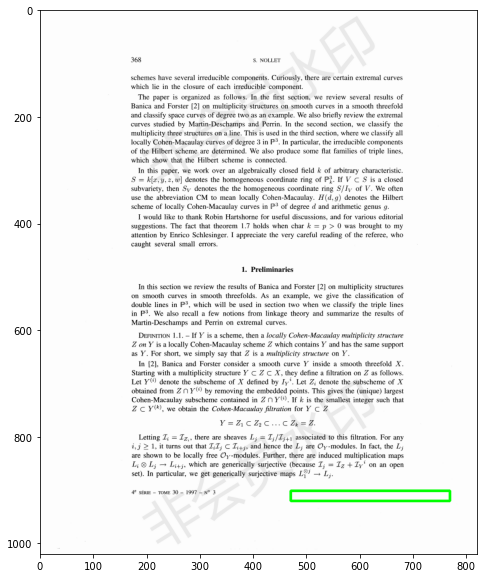

In [17]:
%matplotlib inline
import utils 
import importlib
from matplotlib import pyplot as plt 
import cv2
importlib.reload(utils)

fig = plt.figure(figsize=(12,10))

# [1,2,200,5]
# we only care about math class
# hence select detections[image_id, class, detection_id, detection_score] class=1 for math
image = cv2.imread(image_path, cv2.IMREAD_COLOR) 

detections = y.data
k = 0
i = 1
j = 0
recognized_boxes = []
recognized_scores = []
print(image.shape)
scale = torch.Tensor([img.shape[1], img.shape[0],
                     img.shape[1], img.shape[0]])
while j < detections.size(2) and detections[k, i, j, 0] >= 0.5:
    score = detections[k, i, j, 0]
    pt = (detections[k, i, j, 1:] * args.window).cpu().numpy()
    coords = (int(pt[0]), int(pt[1]), int(pt[2]), int(pt[3]))
    recognized_boxes.append(coords)
    recognized_scores.append(score.cpu().numpy())
    
    j += 1
print(recognized_boxes)
print(coords)
# utils.draw_boxes(args,image,recognized_boxes,recognized_scores,debug_boxes,debug_scores,scale,'1')
cv2.rectangle(image, (coords[0], coords[1]), (coords[2], coords[3]), (0, 255, 0), 3)
plt.imshow(image)
plt.show()